# <font color='#069af3'> Plotting & animations</font>

## Introduction

In this notebook, we will:
1. Read in the data we generated in the 2nd notebook
2. Apply some simple statistics on the data
3. Generate some perspective quasi-3D plots
4. Generate geospatial plots, with the number of rainy days being shown in a form of a colourmap and an animated plot, showing the colourmaps for every year studied

## <font color='#069af3'>STEP 0</font>: Importing useful libraries

In [1]:
!pip install contextily
!pip install mplcursors

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.4 MB/s eta 0:00:00


In [2]:
# Interactive backend (for interactive plotting)
%matplotlib notebook

# For displaying static plots
%matplotlib inline

# For displaying interactive plots
import plotly.graph_objs as go

# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# For plotting (perspective plots)
from matplotlib.collections import PolyCollection


# For plotting geospatial plots
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx


# For interactive display of city when hovering over w/ mouse
import mplcursors


# For the animated plot
from matplotlib.animation import FuncAnimation

# For accessing files in Google Drive
from google.colab import drive

# Import Image and display functions
from IPython.display import Image, display




## <font color='#069af3'>STEP 1</font>: Read the data file in the form of a dataframe

In this step, we will read in the data file we generated in the previous notebook in the form of a pandas dataframe.
The file containes the names of the 270 UK cities and the average rainy days per year from 2001 up to 2023 for these cities.

In [3]:
# Mount contents of Google Drive
drive.mount('/content/drive')

rain_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/rain_AVG_city.txt", sep='\s+')

# Print dataframe to check
print(rain_data)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
           CITY  2001  2002  2003  2004  2005  2006  2007  2008  2009  ...  \
0        london   139   130    91   130   105   124   111   121   109  ...   
1    birmingham   125   134   103   136   112   129   122   143   131  ...   
2       glasgow   151   193   151   177   155   182   160   185   176  ...   
3     edinburgh   127   170   119   147   131   153   134   168   149  ...   
4     liverpool   173   174   153   198   159   182   172   185   178  ...   
..          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
265   aldershot   133   135    93   128   102   124   118   125   116  ...   
266    abingdon   134   134    95   128   109   124   116   130   123  ...   
267    aberdare   138   170   131   148   137   152   143   165   152  ...   
268   port-erin   143   177   139   171   139   169   144   156   166  ...   
269       lax

## <font color='#069af3'>STEP 2</font>: Simple statistics

In this step, we will perform some very simple statistics on the dataset

### 2a: Which UK city was the rainiest in 2021?

In [4]:
# Find idx of max
max_val = np.max(rain_data["2021"])
rain_2021_IDX = np.where( (rain_data["2021"] == max_val) )

Note that here we did not use `np.argmax` to find the index of the maximum, in case there are multiple cities with the same maximum value and `np.agmax` only returns one index

In [5]:
# Find city corresponding to idx
City_rain_2021 = rain_data["CITY"].iloc[rain_2021_IDX]

# Print result
print("The raininest cities in 2021 were:", *City_rain_2021, sep = "\n")

The raininest cities in 2021 were:
ben-nevis


Makes sense that Ben Nevis is the rainiest location, since it's the highest mountain in Scotland, the United Kingdom, and the British Isles (Source: https://en.wikipedia.org/wiki/Ben_Nevis)

### 2b: Which UK city is the rainiest on average (from 2001 up to 2023) ?

In [6]:
# Find AVG rainy days per year for each city
AVG_rain_ALL = [np.average(rain_data.iloc[row, 1:])
                for row in range(len(rain_data))]

# Find max value
max_val_ALL = np.max(AVG_rain_ALL)

# Find max value index
max_idx_ALL = np.where( (AVG_rain_ALL == max_val_ALL) )

# Find name of the rainiest city
Rainiest_city = rain_data["CITY"].iloc[max_idx_ALL]

# Print result
print("The raininest cities since 2000 are:", *Rainiest_city, sep = "\n")



The raininest cities since 2000 are:
ben-nevis


### 2c: How many days does it rain in the UK on average?

In [7]:
# Find AVG over all cities
AVG_rain = int(np.average(AVG_rain_ALL))

# Print result
print("On average in the UK, it rains", AVG_rain, "days per year")

On average in the UK, it rains 139 days per year


## <font color='#069af3'>STEP 3</font>: Generating glass-like perspective plots

Now, we will plot the data set in the form of perspective plots

First, we will need to format our data in order to generate polygons for our plot:
* **X array**: Repeat the "years" column for each city
* **Y array**: Data array contianing rainy days per year for each city and each year
(same as the rain_data dataframe, without the city names)
BUT shifted upwards, so that the y-axis starts from 0. Otherwise, the plot would be misaligned w.r.t. to the 3D wire frame

* **Z array**: The index of each city, to space out data for better visualisation

In [8]:
# Get array with years (from txt file)
years = np.loadtxt("/content/drive/My Drive/Colab Notebooks/rain_AVG_city.txt", usecols = range(1, 24), max_rows = 1)

#  X = YEAR
x = np.repeat(years[np.newaxis], len(rain_data["CITY"].iloc[1:]), axis = 0).T

print("X =", x)

# Y = AVG rainy days
y = np.array(rain_data.iloc[:, 1:]).T

print("Y =", y)

y_new = [ y[:,i] - np.min(y[:,i])
                 for i in range(len(rain_data)) ]

# Convert to 2D arr (from list of arr)
y_new = np.stack(y_new, axis = 1)

# Z = idx for each CITY
z = np.arange(0, len(rain_data["CITY"].iloc[1:]))

X = [[2001. 2001. 2001. ... 2001. 2001. 2001.]
 [2002. 2002. 2002. ... 2002. 2002. 2002.]
 [2003. 2003. 2003. ... 2003. 2003. 2003.]
 ...
 [2021. 2021. 2021. ... 2021. 2021. 2021.]
 [2022. 2022. 2022. ... 2022. 2022. 2022.]
 [2023. 2023. 2023. ... 2023. 2023. 2023.]]
Y = [[139 125 151 ... 138 143 152]
 [130 134 193 ... 170 177 171]
 [ 91 103 151 ... 131 139 145]
 ...
 [130 140 171 ... 181 154 158]
 [119 137 197 ... 193 177 175]
 [135 165 187 ... 217 188 185]]


Define vertices of polygons for each city (z values) in tuple form (xs, ys) ---> (year, rainy_days)
<br>
The first and last elements of the vertices array have x = 0 so that polygons start and end at the x-axis

In [9]:
# Generate vertices array
verts = []
for zi in range(len(z)):

    xs = np.concatenate([[x[0,zi]], x[:,zi], [x[-1,zi]]])
    ys = np.concatenate([[0], y_new[:,zi], [0]])

    # Vertices (of polygons): (X = Year; Y = Rainy days)
    verts.append(list(zip(xs, ys)))


# Set colourmap
facecolors = plt.colormaps['plasma'](np.linspace(0, 1, len(verts)))

# Plot vertices as polygons
poly = PolyCollection(verts, facecolors = facecolors)

# Set transparency to 0.5
poly.set_alpha(0.5)

Now, plot polygons and format axes

Text(0.5, 0, 'Rainy days')

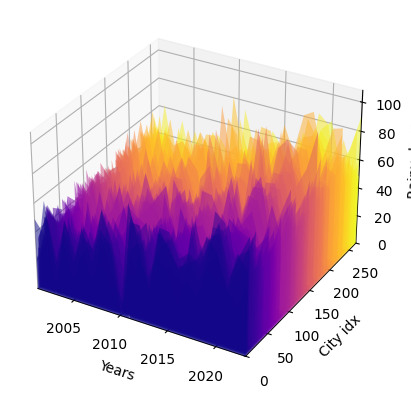

In [10]:
# Initialise plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot and flip x and z axis (so that z shows the different cities)
ax.add_collection3d(poly, zs = z, zdir='y')

# Set axis limits & labels

# X
ax.set_xlim3d(x.min(), x.max())
ax.set_xlabel('Years')

# Y
ax.set_ylim3d(z.min(), z.max())
ax.set_ylabel('City idx')

# Z
ax.set_zlim3d(y_new.min(), y_new.max())
ax.set_zlabel('Rainy days')

The problem with this plot is that it becomes very cumbersome for a large amount of data. Therefore, if we want to compare the trends in the rainy days between the different cities, we should study only a few of them at a time.
<br>
Now, we will isolate the data for the first 5 cities and plot the perspective-type of plot, while also changing the position of the camera and formatting the axes to make the visualisation as clear as possible.

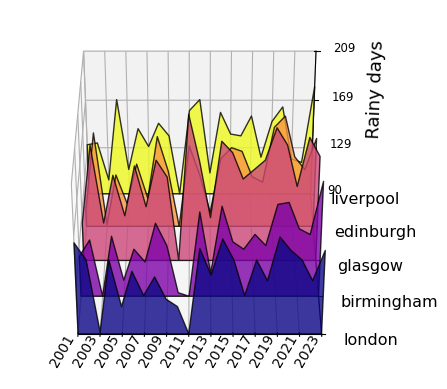

In [11]:
# Isolate the 5 first cities
x_5 = x[:,:5]
y_5 = y_new[:,:5]
z_5 = np.arange(0, 500, 100) # spaced out by 10 units


# Array containing the vertices of the polygons
verts_5 = []
for zi in range(len(z_5)):

    xs_5 = np.concatenate([[x_5[0,zi]], x_5[:,zi], [x_5[-1,zi]]])
    ys_5 = np.concatenate([[0], y_5[:,zi], [0]])

    # Append to list
    verts_5.append(list(zip(xs_5, ys_5)))



# Viridis colourmap
facecolors_5 = plt.colormaps['plasma'](np.linspace(0, 1, len(verts_5)))

# Add facecolour from cmap; black contour
poly_5 = PolyCollection(verts_5, facecolors = facecolors_5, edgecolors = "Black")

# Make plot semi-transparent
poly_5.set_alpha(0.8)



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# re-orient axes: show "rainy days" on y-axis
ax.add_collection3d(poly_5, zs = z_5, zdir='y')


# Adjust camera positions
ax.azim = 270  # rotate around z-axis => Front view
ax.elev = 35  # elevation => look from above
ax.dist = 20  # zoom




# Set axis limits & labels & positions


## X - axis ##

# Adjust gap between axis; tick label; font size
ax.tick_params(axis='x', pad = 7, labelsize = 10)

# Adjust ticks; labels; position of labels
ax.set_xticks(ticks = np.arange(int(years[0]), int(years[-1] + 2), 2),
              labels = np.arange(int(years[0]), int(years[-1] + 2), 2),
              rotation = 60, va='baseline', ha='right')

# Set axis limits
ax.set_xlim3d(x_5.min(), x_5.max())



## Y - axis ##

# Adjust gap between axis; tick label; font size
ax.tick_params(axis='y', pad = 5, labelsize = 11.5)

# Adjust ticks; labels = CITY names; position of labels
ax.set_yticks(ticks = z_5, labels = rain_data["CITY"].iloc[0:5],
              rotation = 0, va='bottom', ha='left')

# Set axis limits
ax.set_ylim3d(z_5.min(), z_5.max())




## Z - axis ##

# Adjust gap between axis; tick label; font size
ax.tick_params(axis='z', pad = 3, labelsize = 8.5)


# Set ticks (shifted data); labels (original data)
ax.set_zticks(ticks = np.linspace(y_5.min(), y_5.max(), num = 4),
              labels = np.linspace(y[:,:5].min(), y[:,:5].max(),
                                   num = 4).astype(int),
              rotation = 0, va='top', ha='left')


ax.set_zlabel('Rainy days', labelpad = 20, fontsize = 13)

# Set axis limits (shifted vals)
ax.set_zlim3d(y_5.min(), y_5.max())


# Zoom in by adjusting distance between plot & camera
ax.dist = 8

Note that the values on the y-axis (rainy days) had been shifted so they would start at y = 0.
<br>
However, the labels on the axis correspond to the values of the original, un-shifted data. This was achieved by
setting the ticks based on the shifted data and writing the labels based on the original values.

#### <font color='#069af3'>Conclusion?</font>

* The benefit of this type of plots is that thanks to the perspective and the transparency, we can look at multiple 2D plots at the same time and compare them, drawing qualitative results.
<br>
<br>
* We can tell that the overall rain patterns are similar between the 5 cities, with some exceptions. For example, in 2011 even though it rained the least in  **<font color='#0c0786'>London</font>** and **<font color='#7e03a7'>Birmigham</font>**, it rained the most in **<font color='#cb4777'>Glasgow</font>**, **<font color='#f89540'>Edinburgh</font>** and **<font color='#eff821'>Liverpool</font>**.

## <font color='#069af3'>STEP 4</font>: Geospatial colourmaps
Since our data refers to different cities in the UK, we can plot their location
on the map.
<br>
Then, we can compare respective rainy days with the use of a colourmap.
<br>
Finally, we will make an animated plot (or gif) showing the geospatial colour maps for each year from 2001 to 2023.

An easy and straightforward way of generating this kind of plots is through the use of ``geopandas``, which extends the well-known ``pandas`` library by adding support for geospatial data.
<br>
_Source: https://geopandas.org/en/stable/getting_started/introduction.html_

We will start by converting our dataframe to a geopandas dataframe, by adding a "geometry" column, as shown in the figure below. This column will contain the coordinates of each city, after they have been converted from the (Longitude, Latitude) format into spatial points:

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


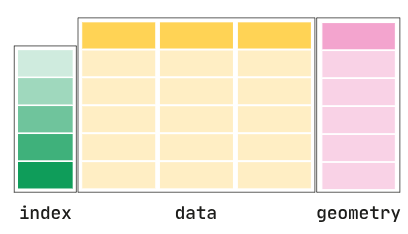

In [12]:
# Upload image from Google Drive
drive.mount('/content/drive')

# Path
img_path = '/content/drive/My Drive/Colab Notebooks/geodf.png'

# Display image
display(Image(filename=img_path))

In [13]:
# Read in coordinates for each city
coords_cities = pd.read_csv("/content/drive/My Drive/Colab Notebooks/City_coords.txt", sep='\s+')


# Zip coordinates into a single column
coords_cities['coords'] = list(zip(coords_cities.Longitude,
                                   coords_cities.Latitude))

# Convert dataframe to GEOdataframe & convert each coord. into a point
GEO_df = gpd.GeoDataFrame(rain_data, crs = "epsg:4326",
                          geometry = coords_cities['coords'].apply(Point))

Now, we have created our geopandas dataframe and we have converted the points to the coordinate reference system (CRS), which tells Python how those coordinates relate to places on the Earth.
<br>
Here, we have used the commonly used CRS World Geodetic System 1984, which expresses locations on the Earth's surface, using the latitude and logitude, by passing the argument ``crs = epsg:4326``(because the points in the geometry section of the geodataframe were expressed using the longitude and latitude of each city)
<br>
_Source: https://geopandas.org/en/stable/docs/user_guide/projections.html_

In [14]:
# Print crs info
GEO_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### 4a: Colourmap for one year (2001)


We now seek plot our geopandas dataframe for the first year (2001). But, we also want to add a background map of the UK in the same figure, so that we can visualise the exact location of each city.
<br>
The background map is added through the use of web map tiles from freely available maps (here, we used openstreetmap), with the help of the ``contextily`` package.
<br>
Usually, web map tiles are expressed in the Web Mercator coordinate system, so we first have to convert the CRS of our data before adding the background map (``epsg = 3857``)
<br>
_Source: https://geopandas.org/en/stable/gallery/plotting_basemap_background.html_

<function __main__.show_annation1(sel)>

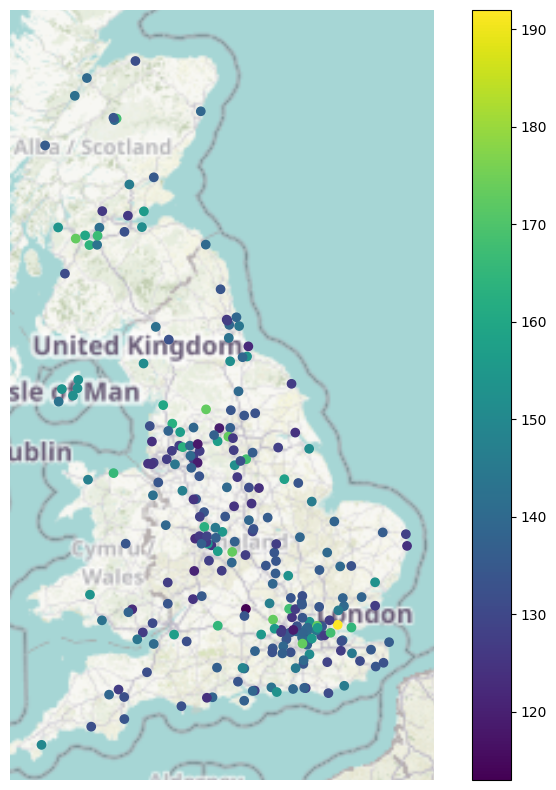

In [15]:
# Change CRS to match the web map tiles
GEO_df= GEO_df.to_crs(epsg = 3857)


# Plot city locations (for 2001)
ax1 = GEO_df.plot(column = "2001", legend = True, figsize = (10, 10),
                    categorical = False, cmap = "viridis")


# Categorical = False => plots cmap according to vals (instead of index)


# Set (x,y) limits through some experimentation (otherwise cropped)
ax1.set_xlim(-630000, 250000)
ax1.set_ylim(6.4e6, 8e6)

# Hide axes for a nicer visualisation
ax1.axis("off")


# Add background map, using web map tiles from URL
ctx.add_basemap(ax1,
                source ='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png',
                zoom = 5,
                alpha = 0.8)

# zoom in for higher resolution
# Change transparency through alpha


##  Hover over with the mouse to see city names ##

# Generate a list of the city names (faster than reading through df)
city_names = GEO_df['CITY']

# Using plotly
fig = go.Figure(
    data=go.Scatter(
        x=x_data,
        y=y_data,
        mode='markers+text',       # 'markers+text' shows both points and hover text
        text=city_names,           # Set custom hover text for each point
        hoverinfo='text',          # Use the text for hover information
        marker=dict(size=10, color='blue')
    )
)




'''
# Function to customise the labels of the points
def show_annation1(sel):
    index = round(sel.target.index)
    sel.annotation.set_text(city_names[index])


# Enable cursor hovering feature
cursor1 = mplcursors.cursor(ax1, hover=True)
cursor1.connect('add', show_annation1)

# Using plotly (supported by Google Colab)
fig = go.Figure(data=go.Scatter(x=x_data, y=y_data, mode='markers', text=['A', 'B', 'C', 'D'], hoverinfo='text'))
fig.show()
'''


In the second part of the script, we used the ``mplcursor`` library, in order to display the name of the city corresponding to each scatter point, when hovering over with the mouse. Thanks to this interactive feature, we avoid having overlapping labels, which would be unreadable.
<br>
<br>
_**Please note that due to the large number of points, this interactive feature is lagging, and works best when hovering over a point, moving the mouse slightly left and right, and waiting for the loading icon.**_

#### <font color='#069af3'>Conclusion?</font>

* The geospatial colourmap is a better way of visualising the distribution of the rainy days within the UK, compared to the perspective plots. This is because it enables us to compare the amount of rainy days per year between all of the 270 cities studied.
<br>
<br>
* For 2001, we can see that the rainiest location was the Ben Navis mountain in Scotland, which is the only yellow point. The next rainiest places (shown in green) were also located in Scotland (Ayr, Greenock). Similar number of rainy days were seen in the northwest of England (Liverpool, Blackpool, Southport), while the West Midlands and the south were the least rainy.



### 4b: Animated geospatial colourmaps

Now, if we want to compare rain patterns over the years, we can plot a map for each year and generate an animation.
<br>
<br>
We can do this by using the ``FuncAnimation`` package of the ``matplotlib.animation`` library.
<br>
<br>
First, we need to write a function that plots the colourmap and adds the basemap in the same figure (ax). This function takes as inputs the "frame" variable, which acts as an iterator (i) and the "ax" argument, which is the subfigure generated at each iteration.
<br>
<br>
_**Note**_: _The minimum and maximum values of the rain data change every year. So, the colourmap is adjusted accordingly for every iteration, and so the colourbar should be updated as well. However, after numerous tries, I have been unsccessful in plotting a new colourbar at every iteration._

In [16]:
# Function plotting colourmap and background map
def plotting_fun(frame, ax):

    # INPUTS: frame= iterator;
    # ax = subfigure generated at every iteration

    # STEP 1: Convert each year to string of integer
    yr = str(int(years[frame]))

    # STEP 2: Plot cmap for one year

    # 2a: Clear the existing plot from the axis
    ax.clear()


    # 2b: Plot cmap on axis "ax"
    im = GEO_df.plot(column = yr, legend = False, ax = ax, figsize = (10, 10),
                        categorical = False, cmap = "viridis",
                        markersize = 10)

    # STEP 3: Add basemap
    ctx.add_basemap(ax,
                    source ='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png',
                    zoom = 5,
                    alpha = 0.8)

    # STEP 4: Axis formatting & title

    # 4a: Set axes limits
    ax.set_xlim(-630000, 250000)
    ax.set_ylim(6.4e6, 8e6)

    # 4b: Plot title = year
    ax.set_title("%s" %yr, fontsize = 20)

    # 4c: Hide axes
    ax.axis("off")

Now that we have the plotting function ready, we can pass it to ``FuncAnimation``, which automatically iterates through every frame and generates a new plot each time. "Frame" ranges from 0 to 22, since we passed the argument ``frames = np.arange(0, len(years))``, with one frame representing one year, from 2001 to 2023.
<br>
After generating the animated plot, we have to save it. Otherwise, the animation object will be garbage collected and we will not be able to visualise the animation.
<br>
_**Source: https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html#matplotlib.animation.FuncAnimation**_

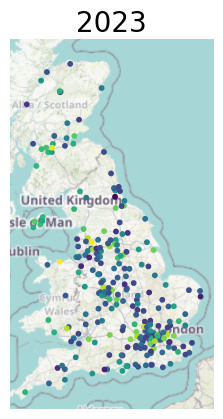

In [17]:
# Initialise fig,ax objects
fig, ax = plt.subplots()


# Generate animation on new "axis" (subplot) every time
ani = FuncAnimation(fig, plotting_fun, fargs=(ax,),
                    frames = np.arange(0, len(years)),
                    interval = 800)

# Save animation
ani.save('yearly_rain.gif', writer='Pillow')


# Show animation
plt.show()